CANCER DETECTION USING DEEP LEARNING

In [140]:
# Dataset used can be found at https://www.kaggle.com/datasets/hamzahabib47/brain-cancer-detection-mri-images/data

import warnings
warnings.filterwarnings('ignore')

In [83]:
# Importing the relevant libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [84]:
# count the number of images in respective classes, 0 - brain tumor and 1 - healthy

root_dir = '/Users/sohapervez/desktop/cancer_project/Dataset'

# number_of_images is a dictionary, key = folder, value = number of images in the folder
number_of_images = {}

# This for loop will go through the 2 folders in the root directory
for dir in os.listdir(root_dir):
    number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

number_of_images.items()

dict_items([('healthy', 408), ('tumor', 392)])

We will split the data such as

- 70% is for training
- 15% for validation
- 15% for testing

In [85]:
def dataFolder(path, split):
    # we will create a train folder

    if not os.path.exists('./'+path):
        os.mkdir('./'+path)

        for dir in os.listdir(root_dir):
            os.makedirs('./'+path+'/' + dir)

            # -2 because we don't want to lose a lot of images or want an unnecessary error
            for img in np.random.choice(a = os.listdir(os.path.join(root_dir, dir)), 
                                        size = (math.floor(split*number_of_images[dir]) - 5),
                                        replace = False):

                O = os.path.join(root_dir, dir, img)
                D = os.path.join('./'+path, dir)
                shutil.copy(O,D) #shutil transfers files from one folder to other
                os.remove(O)

    else:
        print(f'{path} folder exists')

In [86]:
dataFolder('train', 0.7)

In [87]:
dataFolder('validation', 0.15)

In [88]:
dataFolder('test', 0.15)

In [89]:
for dir in os.listdir(root_dir):
    number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

number_of_images.items()

dict_items([('healthy', 16), ('tumor', 17)])

Model Build

In [9]:
# Importing the relevant libraries

from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
import keras

In [10]:
# CNN Model
# CNN is the most popular algorithm that's being used for computer vision
# To avoid overfitting, we are using maxpool (pulling layer)
# Convulation layers are the features of the image

'''model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))

model.add(Conv2D(filters = 36, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout will decrease the amount of data by that rate
model.add(Dropout(rate = 0.25)) # retaining 75% of data

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [11]:
# The loss is binary loss because we are doing binary classification i.e. whether the image is cancerous or not (from scratch model)

'''model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])'''

Preparing our data using Data Generator

In [96]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input

In [97]:
def preprocessingImages1(path):
    '''
    input : Path
    output : Pre processed images
    '''
    image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, preprocessing_function = preprocess_input, horizontal_flip = True)
    image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

    return image

In [98]:
path = '/Users/sohapervez/desktop/cancer_project/train'
train_data = preprocessingImages1(path)

Found 549 images belonging to 2 classes.


In [99]:
# This shows that if it's 0 it means healthy and 1 means tumor

train_data.class_indices

{'healthy': 0, 'tumor': 1}

In [100]:
# doing the same thing for validation
# removing zoom_range, shear_range, and horizontal flip because we want data to be as natural as possible in validation.
# we don't want a model that works only on our training dataset because when we launch in production
# we don't know what type of data we are going to have

def preprocessingImages2(path):
    '''
    input : Path
    output : Pre processed images
    '''
    image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
    image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

    return image

In [101]:
path = '/Users/sohapervez/desktop/cancer_project/test'
test_data = preprocessingImages2(path)

Found 109 images belonging to 2 classes.


In [102]:
path = '/Users/sohapervez/desktop/cancer_project/validation'
val_data = preprocessingImages2(path)

Found 109 images belonging to 2 classes.


In [68]:
# Early stopping and model check point (from scratch model)

#from keras.callbacks import ModelCheckpoint, EarlyStopping

'''from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 6, verbose = 1,)

# model check point
mc = ModelCheckpoint(monitor = 'val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True,)

cb = [es, mc]'''

Model Training (Transfer Learning)

In [103]:
# Now using a pre-trained model to train our model and see how well we get the accuracy

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model

In [104]:
# Creating a functional model

base_model = MobileNet(input_shape = (224, 224, 3), include_top = False)

17225924/17225924 [==============================] - 2s 0us/step


In [105]:
# Freezing the layers means the weights of these layers (like detecting edges, shapes, or textures in images)
# will not be updated during training on our dataset

for layer in base_model.layers:
    layer.trainable = False

In [108]:
X = Flatten()(base_model.output)
X = Dense(units = 1, activation = 'sigmoid')(X)

model = Model(base_model.input, X)

In [109]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [110]:
model.compile(optimizer = 'rmsprop', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [111]:
# call back

# model check point
mc = ModelCheckpoint(filepath = 'bestmodel.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

# early stopping
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1)

cb = [mc, es]

In [113]:
# training the model

hist = model.fit(train_data,
                steps_per_epoch = len(train_data),
                epochs = 30,
                validation_data = val_data,
                validation_steps = len(val_data), 
                callbacks = cb)

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 4.1146e-05 - accuracy: 1.0000
Epoch 1: val_accuracy improved from 0.95413 to 0.97248, saving model to bestmodel.h5
18/18 [==============================] - 6s 341ms/step - loss: 4.1146e-05 - accuracy: 1.0000 - val_loss: 0.3503 - val_accuracy: 0.9725
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.9545
Epoch 2: val_accuracy did not improve from 0.97248
18/18 [==============================] - 5s 297ms/step - loss: 0.4436 - accuracy: 0.9545 - val_loss: 0.5126 - val_accuracy: 0.9633
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 2.6654e-05 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.97248
18/18 [==============================] - 6s 318ms/step - loss: 2.6654e-05 - accuracy: 1.0000 - val_loss: 0.4832 - val_accuracy: 0.9633
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 2.4371e-04 - accuracy: 1.0000
Epoch 4: val_accuracy im

Here we can see that our model has started with an accuracy of 97%. Previously when we trained from scratch, it started with an
accuracy of 93%. With pre-trained model it has improved.

In [114]:
# load the best fit model

model = load_model('/Users/sohapervez/desktop/cancer_project/bestmodel.h5')

In [116]:
# checking the accuracy of the model

acc = model.evaluate_generator(test_data)[1]

print(f'our model accuracy is {acc * 100} %')

our model accuracy is 97.24770784378052 %


We can see that our model accuracy has increased by 6%. Initially, it was 91% when we built the model from scratch.

In [117]:
h = hist.history

h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

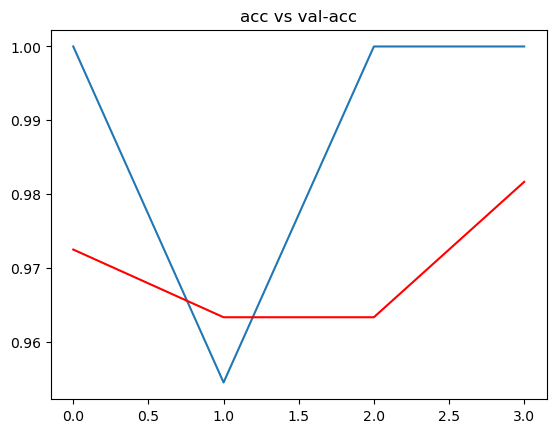

In [119]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title('acc vs val-acc')
plt.show()

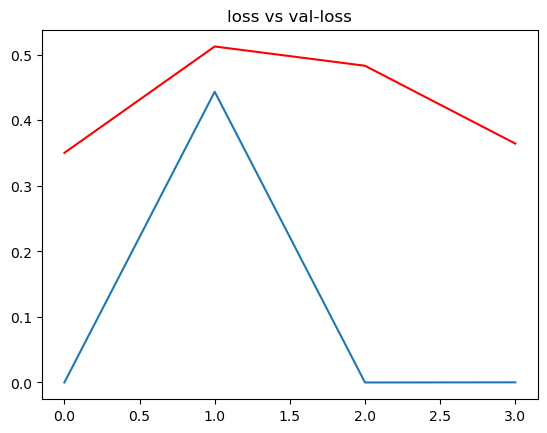

In [121]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title('loss vs val-loss')
plt.show()

About this plot:

Initial Behavior:

- Loss decreases steadily (blue line), indicating the model learns quickly.
- Validation loss (red line) starts high, peaks early, and then decreases, showing some improvement in generalization after the first epoch.

Stability:

- After a few epochs, training loss stabilizes at a low value, indicating that the model has learned the task effectively.
- Validation loss remains higher than training loss, suggesting slight overfitting.

Generalization:

The gradual decrease in validation loss after epoch 1 suggests the model generalizes reasonably well to unseen data.

The transfer learning model is significantly better because:

1. It stabilizes faster and achieves a lower loss.
2. It generalizes better to unseen data (as seen in the lower validation loss after the initial peak).
3. Training from scratch struggles due to a lack of pre-trained knowledge, requiring more epochs, better initialization, or additional data.

In [131]:
from tensorflow.keras.utils import load_img, img_to_array

1/1 [==============================] - 0s 31ms/step
Prediction (Probability): 1.0964470434013385e-12
The MRI image is of a healthy brain


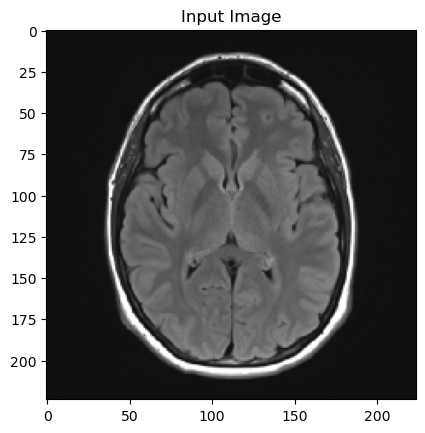

In [139]:
path = '/Users/sohapervez/desktop/cancer_project/Dataset/healthy/healthy (403).jpg'

img = load_img(path, target_size = (224, 224))

# Normalization is done so that inputs have consistent ranges across all dimensions.
input_arr = img_to_array(img)/255 #dividing for normalization

# The shape of input_arr after normalization is (224, 224, 3) for a single RGB image.
input_arr.shape

# model expects a batch of images as input, even if we pass only one image.
# The shape becomes (1, 224, 224, 3).
# 1 is the batch size (indicating one image in the batch).
input_arr = np.expand_dims(input_arr, axis=0)  # Expanding dimensions

# Get the prediction (probability)
pred = model.predict(input_arr)  # This returns a value between 0 and 1 for binary classification
print(f"Prediction (Probability): {pred[0][0]}")  # Assuming model outputs shape (1, 1)

# Determine the class based on threshold
threshold = 0.5  # Default threshold for binary classification
class_label = (pred[0][0] > threshold).astype("int") # converts the probability to a binary class (0 or 1)

# Interpret the result
if class_label == 0:
    print('The MRI image is of a healthy brain')
else:
    print('The MRI image is of a brain tumor')

# Display the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

Model training (model built from scratch)

In [69]:
'''hs = model.fit(train_data, steps_per_epoch = len(train_data), epochs = 30, verbose = 1, validation_data = val_data,
                         validation_steps = len(val_data), callbacks = cb)'''

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9964
Epoch 1: val_accuracy improved from -inf to 0.93578, saving model to ./bestmodel.h5
18/18 [==============================] - 15s 795ms/step - loss: 0.0072 - accuracy: 0.9964 - val_loss: 0.2611 - val_accuracy: 0.9358
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9781
Epoch 2: val_accuracy did not improve from 0.93578
18/18 [==============================] - 16s 857ms/step - loss: 0.0893 - accuracy: 0.9781 - val_loss: 1.0259 - val_accuracy: 0.9083
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9362
Epoch 3: val_accuracy did not improve from 0.93578
18/18 [==============================] - 15s 845ms/step - loss: 0.1894 - accuracy: 0.9362 - val_loss: 0.2627 - val_accuracy: 0.9266
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9763
Epoch 4: val_accuracy did not improve from

In [70]:
# Model graphical interpretation

'''h = hs.history
h.keys()'''

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

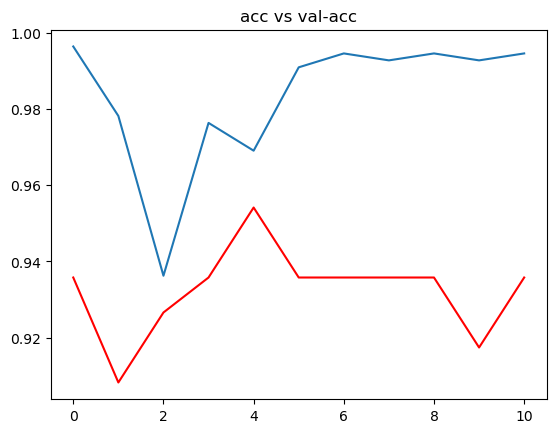

In [71]:
# Visualization for accuracy vs validation accuracy

'''import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')

plt.title('acc vs val-acc')
plt.show()'''

About the plot

This plot indicates a balanced training process where the model performs well on both training and validation sets, achieving high accuracy without overfitting. The smaller patience value played a role in stopping training at the right time.

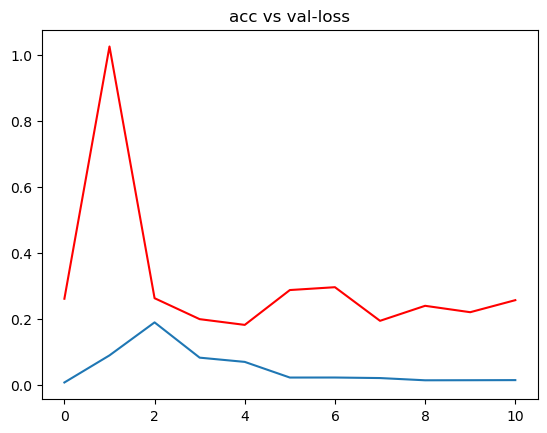

In [72]:
# Visualization for loss vs validation loss

'''plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')

plt.title('acc vs val-loss')
plt.show()'''

About the plot

Erratic Behavior:

- Loss fluctuates significantly across epochs, indicating difficulty in learning meaningful patterns.
- Validation loss starts high and remains erratic, suggesting poor generalization and possible instability in training.

Performance:

- Loss does not converge effectively, and validation loss remains consistently higher, highlighting the model's limited ability to fit the data.
  
- Training Challenges:

The model likely struggles due to a lack of pre-trained knowledge and insufficient data or features to learn efficiently.

In [73]:
# Model accuracy

'''from keras.models import load_model

model = load_model('/Users/sohapervez/desktop/cancer_project/bestmodel.h5')''' # loading our best model

Model Accuracy

In [23]:
# This will return loss and accuracy and we want accuracy; therefore, we have taken index 1

'''acc = model.evaluate_generator(test_data)[1]

print(f'the accuracy of our model is {acc * 100} %')'''

the accuracy of our model is 91.74311757087708 %


In [24]:
# checking if our model tells if a given image is cancerous or not

'''from tensorflow.keras.utils import load_img, img_to_array'''

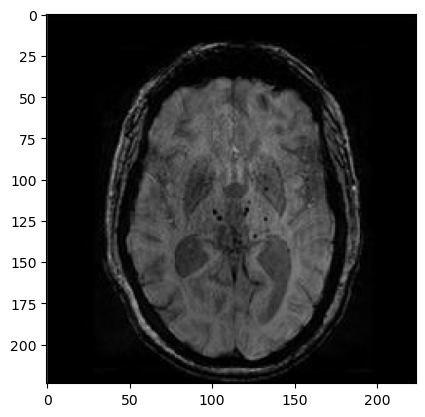

1/1 [==============================] - 0s 30ms/step
[[0]]


In [80]:
'''path = '/Users/sohapervez/desktop/cancer_project/Dataset/healthy/healthy (11).jpg'

img = load_img(path, target_size = (224, 224))

# Normalization is done so that inputs have consistent ranges across all dimensions.
input_arr = img_to_array(img)/255 #dividing for normalization

plt.imshow(input_arr)
plt.show()

# The shape of input_arr after normalization is (224, 224, 3) for a single RGB image.
input_arr.shape

# model expects a batch of images as input, even if we pass only one image.
# The shape becomes (1, 224, 224, 3).
# 1 is the batch size (indicating one image in the batch).
input_arr = np.expand_dims(input_arr, axis=0)  # Expanding dimensions

# Get predictions
pred = model.predict(input_arr)

# Interpret the result
# 0 means healthy and 1 means cancerous
class_label = (pred > 0.5).astype("int")  # Binary classification (0 or 1)
print(class_label)'''